#Импорт

In [ ]:
# pip install matplotlib==3.4.3

In [ ]:
import plotly.express as px
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV, Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV

from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.chdir('/content/drive/MyDrive/DS/NYC_data') 

In [ ]:
data = pd.concat([
                  pd.read_csv('2019-12.csv',low_memory=True), 
                  pd.read_csv('2020-01.csv',low_memory=True)
                  ])

Описание признаков по ссылке:  
https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13301325 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 1.9+ GB


#Подготовка данных

## Удаление пропущенных данных

Для начала посмотрим на наличие пропущенных данных

Как видим, в датасете имеются 116459 записей с отсутствующими записями по следующим признакам:  

*   VendorID - ID фирмы, оказывающей услуги               
*   Passenger count - количество пассажиров
*   RatecodeID
*   Store_and_fwd_flag
*   Payment_type - тип оплаты



Поскольку нам далее придётся строить модель зависимости стоимости поездки от разных факторов, то придётся удалить записи с недостающими данными, поскольку они могут внести неточность в модель.

In [ ]:
df = data.copy()

In [ ]:
del data

In [ ]:
df.dropna(inplace=True)

## Удаление данных с нулевыми значениями

Посмотрим, в каких колонках есть нулевые значения

In [ ]:
df.eq(0).sum()

Нулевые значения есть в колонках с количеством пассажиров и расстоянием поездки - их мы удалим.  

Также такие значения в колонках, отражающих стоимость цены поездки (общий тариф, сборы, чаевые и т.д.).  

Хотя и можно представить себе поездку с одной определённой нулевой составляющей (как например, чаевые), сложно представить поездку с нулевым базовым тарифым (**fare_amount**) и итоговой стоимостью поездки (**final_amount**). Поэтому нулевые значения с этими двумя признаками мы также удалим

In [ ]:
df = df[(df.passenger_count != 0) & (df.trip_distance != 0) & (df.total_amount != 0) & (df.fare_amount != 0)]

##Удаление данных с отрицательными значениями

Посмотрим, если ли записи с отрицательными значениями

In [ ]:
(df.select_dtypes(np.number) < 0).sum()

Поскольку не один признак не может иметь отрицательное значение, удалим все записи с ними.

In [ ]:
df = df[(df.select_dtypes(np.number) >= 0).all(axis=1)]

## Выбивающиеся даты

Посмотрим, есть ли выбивающиеся даты.

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].describe()

Удалим даты, которые выбиваются из интервала декабрь 2019-январь 2020

In [ ]:
df = df[(df.tpep_pickup_datetime >= pd.Timestamp('2019-12-01')) & (df.tpep_pickup_datetime<= pd.Timestamp('2020-02-01'))
    &  (df.tpep_dropoff_datetime >= pd.Timestamp('2019-12-01')) & (df.tpep_dropoff_datetime<= pd.Timestamp('2020-02-01'))]

## Признак длительности поездки

Создадим признак длительности поездки в секундах

In [ ]:
#Разница между началом и концом поездки
df['duration_of_trip'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
#Переводим разницу в секунды
df['duration_of_trip'] = df.duration_of_trip / np.timedelta64(1, 's')
df['duration_of_trip'].head()

Посмотрим на количество записей с нулевой или отрицательной продолжительностью поездки.

In [ ]:
print(f'В датасете имеется {(df.duration_of_trip <= 0).sum()} запись с нулевой или отрицательной продолжительностью поездки.')

Удаляем эти записи

In [ ]:
df = df[(df.duration_of_trip > 0)]

In [ ]:
df.shape

##One-Hot-Encoding

Поскольку мы будем оценивать вклад признаков в цену, необходимо будет преобразовать номинальные признаки с помощью One-Hot-Encoding.  
Но сначала переведём цифры в текстовые значения.

**Payment type**

A numeric code signifying how the passenger paid for the trip 
   
1= Credit card  
2= Cash  
3= No charge  
4= Dispute  
5= Unknown  
6= Voided trip  

In [ ]:
payment_type_dict = {1: 'credit_card', 2: 'cash', 3: 'no_charge', 4: 'dispute', 5: 'unknown', 6: 'voided_trip'}
df.payment_type =df.payment_type.map(payment_type_dict)

**RateCodeID**

The final rate code in effect at the end of the trip  

1= Standard rate  
2=JFK  
3=Newark  
4=Nassau or Westchester  
5=Negotiated fare  
6=Group ride  
99=Unknown

In [ ]:
RatecodeID_dict = {1: 'standard_rate', 2: 'jfk', 3: 'newark', 4: 'nassau_or_Westchester', 5: 'negotiated_fare', 6: 'group_ride', 99:'unknown'}
df.RatecodeID = df.RatecodeID.map(RatecodeID_dict)

**Store_and_fwd_flag**

This flag indicates whether the trip record was held in vehicle
memory before sending to the vendor, aka “store and forward,”
because the vehicle did not have a connection to the server.  

*Y* - store and forward trip  
*N* - not a store and forward trip

In [ ]:
store_and_fwd_flag_dict = {'N': 'no', 'Y': 'yes'}
df['store_and_forward_trip']= df.store_and_fwd_flag.map(store_and_fwd_flag_dict)

**VendorID**

A code indicating the TPEP provider that provided the record.  

1= Creative Mobile Technologies, LLC  
2= VeriFone Inc.

In [ ]:
vendor_dict = {1: 'CMT', 2: 'VeriFone'}
df['vendor']= df.VendorID.map(vendor_dict)

In [ ]:
del df['VendorID']

Теперь начнём переводить колонки в OHE-формат

In [ ]:
df_ohe = pd.concat([
           df.drop(columns=['payment_type', 'RatecodeID', 'store_and_forward_trip', 'vendor', 'store_and_fwd_flag'], errors='ingore'), 
           pd.get_dummies(df.payment_type, prefix='payment_type').astype(int),
           pd.get_dummies(df.RatecodeID, prefix='ratecode').astype(int),
           pd.get_dummies(df['store_and_forward_trip'], prefix='store&forward').astype(int),
           pd.get_dummies(df['vendor'], prefix='vendor').astype(int),
           pd.get_dummies(df['store_and_fwd_flag'], prefix='store_fwd').astype(int),
], axis=1)

In [ ]:
df_ohe.head()

# Задание 1. Корреляция между стоимостью поездки и другими факторами

Как стоимость поездки скоррелирована с другими факторами? Как вы это можете объяснить?

In [ ]:
df_ohe.shape

(12773989, 27)

In [ ]:
df_ohe.passenger_count = df_ohe.passenger_count.astype(int)

In [ ]:
corrs = df_ohe.drop('total_amount', axis=1).corrwith(df_ohe.total_amount).round(2)

In [ ]:
corrs = corrs.sort_values(ascending=False).to_frame().reset_index()
corrs.columns = ['variable', 'corr']

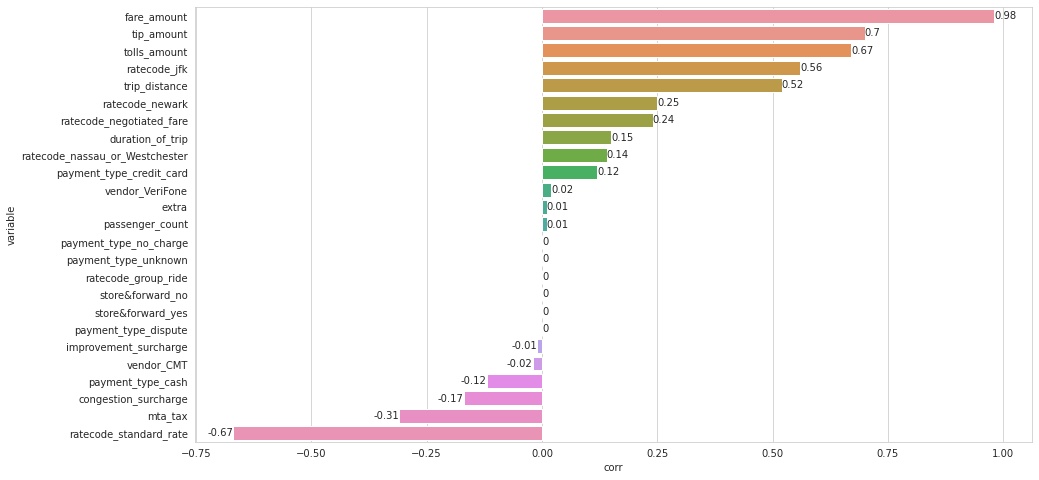

In [ ]:
# plt.figure(figsize=(15,8))
# ax = sns.barplot(corrs['corr'], corrs.variable)
# ax.bar_label(ax.containers[0])
# plt.show()

Для объяснения полученных результатов воспользуемся информацией с тарифами на проезд, доступной по ссылке:  
https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

## Положительная корреляция

Проанализируем каждый признак с высоким значением положительной корреляции.  

*   Fare amount - основа часть стоимости поездки, вычисляемая на базисе её расстояния и продолжительности. Говорит за себя.  
*   Tip amount - размер чаевых, которые дают клиенты. Логично предположить, что чем длиннее поездка, тем больше чаевых оставит клиент.
*   Tolls amount - размер пошлин. Также логично, что чем дороже поездка, тем больше будет совокупная цена пошлин, заложенная в ней.
*   Ratecode JFK/Newark - на странице с информацией о стоимости проезда сказано, что данные тарифа облагаются по более высокой ставке.
*   Trip distance/duration of trip - из этих признаков вычисляется fare amount (судя по всему, связь между ними не совсем линейная.)

In [ ]:
df.groupby('RatecodeID')['total_amount'].agg(['mean', 'count'])

,mean,count
RatecodeID,,
group_ride,4.010833,24
jfk,69.245481,319656
nassau_or_Westchester,89.532434,10101
negotiated_fare,85.290029,35048
newark,92.975904,29750
standard_rate,17.213734,12379001


## Отрицательная корреляция

Наиболее сильным отрицательным признаком оказалось наличие тарифа Standard rate. Плата за данный тариф взимает при стандартной поездке в пределах города, тогда как проезд по другим тарифам (в аэропорты Newark, JFK или за город в Насау или Вэстчестер) взимается по повышенной ставке.  

Далее мы можем видеть сравнительную таблицу средних цен по каждому тарифу. Дешевле стандартного тарифа только group_ride, который слишком малочисленен, чтобы иметь высокое модуль значения в корреляции с целевой переменной.

In [ ]:
df.groupby('RatecodeID')['total_amount'].agg(['mean', 'count'])

,mean,count
RatecodeID,,
group_ride,4.010833,24
jfk,69.245481,319656
nassau_or_Westchester,89.532434,10101
negotiated_fare,85.290029,35048
newark,92.975904,29750
standard_rate,17.213734,12379001


Теперь попытаемся понять, почему mta_tax имеет весьма заметное абсолютное значение корреляции.  
Посмотри, какие значение принимает признак

In [ ]:
df_ohe.mta_tax.value_counts()

0.50    12720031
0.00       53757
0.87         190
3.30           7
0.35           2
0.85           1
3.00           1
Name: mta_tax, dtype: int64

При большинстве поездок взимается сбор в 0.5.  
Отрицательная корреляция может получиться только в случае, если поездок с нулевым сбором оказываются дороже.  
Посмотрим на эти поездки

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df[(df_ohe.mta_tax != 0)]['RatecodeID'].value_counts()

standard_rate            12377439
jfk                        319644
negotiated_fare             12610
nassau_or_Westchester       10100
group_ride                     24
newark                          8
Name: RatecodeID, dtype: int64

In [ ]:
df[(df_ohe.mta_tax == 0)]['RatecodeID'].value_counts()

newark                   29742
negotiated_fare          22438
standard_rate             1562
jfk                         12
nassau_or_Westchester        1
Name: RatecodeID, dtype: int64

Как можно заметить, среди поездок с нулевым сбором большую часть составляют поездки с обговариваемым тарифом (*negotiated_fee*) и поздки до Аэропорта Newark. На странице с тарифами (ссылка приведены выше) можно узнать, что MTA-сбор не взимается на данном тарифе, в отличие от тарифом с поездками в аэропорт JFK, а также за город.  
Далее также можно видеть, что поездки в Newark и с обговариваемым тарифом также в среднем самые дорогие, чем и объясняется отрицательная корреляция.  
Дорогие поездки с этими тарифами в большинстве своём не облагаются MTA-сбором.  

In [ ]:
df.groupby('RatecodeID')['total_amount'].mean()

RatecodeID
group_ride               4.011
jfk                     69.245
nassau_or_Westchester   89.532
negotiated_fare         85.290
newark                  92.976
standard_rate           17.214
Name: total_amount, dtype: float64

# Задание 2. Аномальные поездки

Найдите аномальные поездки. Почему именно эти поездки вы считаете аномальными?

## Итоговая цена поездки

Для начала посмотрим на распределение целевой переменной.

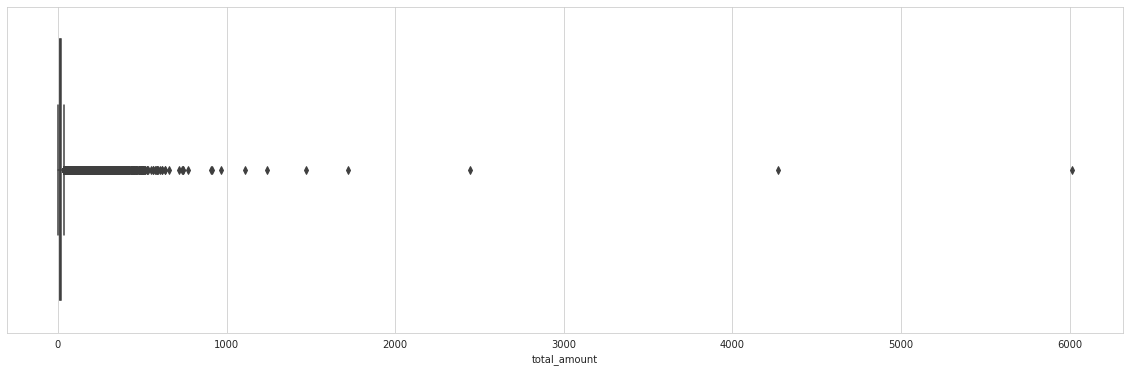

In [ ]:
# plt.figure(figsize=(20,6))
# sns.boxplot(df.total_amount)

Распределение имеет очень тяжёлый правый хвост. Для удобства посмотрим на логарифм от переменной.

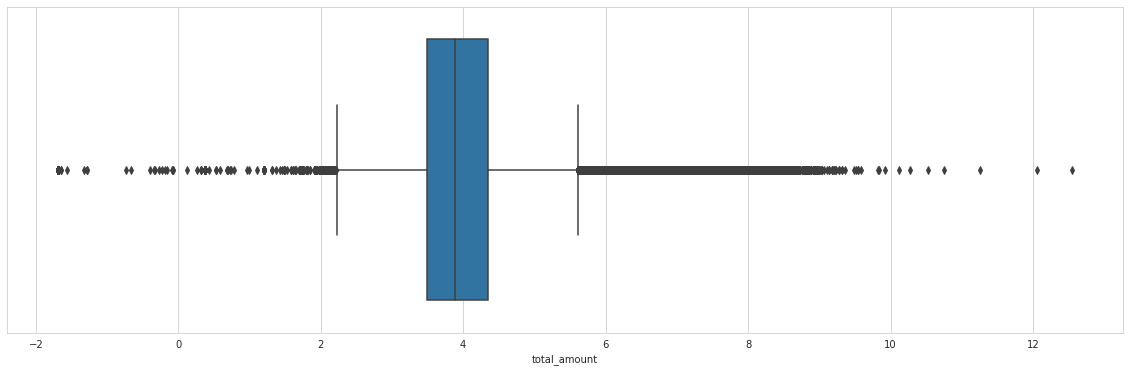

In [ ]:
# plt.figure(figsize=(20,6))
# sns.boxplot(np.log2(df.total_amount))

Логарифм целевой метрики имеет огромное количество выбросов как в меньшую, так и в большую стороны.  
Посмотрим на то, чем они могут быть обусловлены.

In [ ]:
plus_outliers =  df[(stats.zscore(np.log2(df.total_amount)) > 3)]
minus_outliers  =  df[(stats.zscore(np.log2(df.total_amount)) < -3)]
print(minus_outliers.shape, plus_outliers.shape)

(3840, 20) (108896, 20)


### Вклад тарифов

Моя первоначальная гипотеза заключается в том, что высокая цена поездки во многом зависит от выбранного тарифа.  


In [ ]:
plus_outliers.RatecodeID.value_counts(normalize=True)

jfk                      0.408564
newark                   0.233535
negotiated_fare          0.159868
standard_rate            0.149335
nassau_or_Westchester    0.048698
Name: RatecodeID, dtype: float64

Как видим, огромная доля выбросов состоит из поездок до аэропортов, за город и поездок с договорным тарифом.

Для каждого тарифа рассчитаем, какая доля поездок по каждому тарифу относится к выбросам.

In [ ]:
plus_outliers.RatecodeID.value_counts() / df.RatecodeID.value_counts()

group_ride                    NaN
jfk                      0.139214
nassau_or_Westchester    0.525153
negotiated_fare          0.496917
newark                   0.854910
standard_rate            0.001314
unknown                       NaN
Name: RatecodeID, dtype: float64

Среди 4 отмеченных категорий доля выбросов по цене поездки составляет от почти 14% до 85,5%.

То же самое сделаем и с выбросами в меньшую сторону.

In [ ]:
minus_outliers.RatecodeID.value_counts(normalize=True)

standard_rate            0.859635
negotiated_fare          0.132031
group_ride               0.004167
nassau_or_Westchester    0.002083
jfk                      0.001042
unknown                  0.000781
newark                   0.000260
Name: RatecodeID, dtype: float64

Большинство таких выбросов составляют поездки со стандартным тарифом, заметная доля у поездок с договорным тарифом.

Для каждого тарифа рассчитаем, какая доля поездок по каждому тарифу относится к выбросам.

In [ ]:
minus_outliers.RatecodeID.value_counts() / df.RatecodeID.value_counts()

group_ride               0.666667
jfk                      0.000013
nassau_or_Westchester    0.000792
negotiated_fare          0.014472
newark                   0.000034
standard_rate            0.000267
unknown                  0.007335
Name: RatecodeID, dtype: float64

К таким выбросам относится большая часть поездок с тарифом group_ride и поездок с договорным тарифом.

### Анализ экстремальных выбросов

Внимательнее проанализируем 7 наиболее дорогих поездок ценой выше 1000 долларов.

In [ ]:
#Сбрасываем индекс для более лёгкой сортировки
df.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)

In [ ]:
inds_max = np.argpartition(-df.total_amount.values, 7)[:7]
df.loc[inds_max].sort_values(by='total_amount', ascending=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration_of_trip,store_and_forward_trip,vendor
497680,2019-12-03 15:00:58,2019-12-03 15:18:04,1.0,0.20,standard_rate,N,238,141,cash,6012.5,2.5,0.5,0.0,0.0,0.3,6015.8,2.5,1026.0,no,CMT
10555618,2020-01-21 15:38:33,2020-01-27 13:43:40,1.0,1.57,standard_rate,N,186,152,cash,4265.0,0.0,0.5,0.0,0.0,0.3,4268.3,2.5,511507.0,no,VeriFone
2686107,2019-12-12 14:53:37,2019-12-16 09:45:42,1.0,1.07,standard_rate,N,193,193,cash,2442.5,0.8,0.5,0.0,0.0,0.0,2443.8,0.0,327125.0,no,VeriFone
11533853,2020-01-26 00:51:39,2020-01-28 07:18:59,1.0,58.85,standard_rate,N,132,7,cash,1718.5,0.5,0.5,0.0,0.0,0.3,1722.3,2.5,196040.0,no,VeriFone
4141680,2019-12-18 12:48:52,2019-12-20 13:34:47,2.0,1.62,standard_rate,N,193,193,cash,1472.0,0.0,0.5,0.0,0.0,0.3,1472.8,0.0,175555.0,no,VeriFone
7089300,2020-01-03 19:29:51,2020-01-05 12:28:15,1.0,8.27,standard_rate,N,186,152,cash,1238.0,1.0,0.5,0.0,0.0,0.3,1242.3,2.5,147504.0,no,VeriFone
10767027,2020-01-22 16:41:24,2020-01-22 16:49:28,1.0,0.55,standard_rate,N,231,209,credit_card,6.5,1.0,0.5,1100.0,0.0,0.3,1110.8,2.5,484.0,no,VeriFone


Самая дорогая поездка (**497847**) имеет необъяснимо высокий fare_amount (доля тарифа в цене) при малой длительности и расстоянии и нулевых чаевых. Скорее всего, тут имеют место чаевые, которые дали наличными деньгами (в tip_amount учитываются толькое чаевые в тразакциях через кредитную карту).

  


7 по дороговизне поездка (**10767384**), в свою очередь, выделяется высокими чаевыми в 1100 долларов (при общей стоимости поездки в 1100.8$).  

5 из 7 самых дорогих оставшихся поездок имеют аномально высокую длительность: от 2 до 6 дней, при этом 4 из 5 этих поездок имеют малое расстояние (за исключением поездки **11534219**, во время которой было пройдено 58 миль).  

Далее более подробно исследуем связь длительности поездки и расстояния, а также цены.

## Длительность поездки и расстояние

Взглянем на распределение поездок по расстоянию

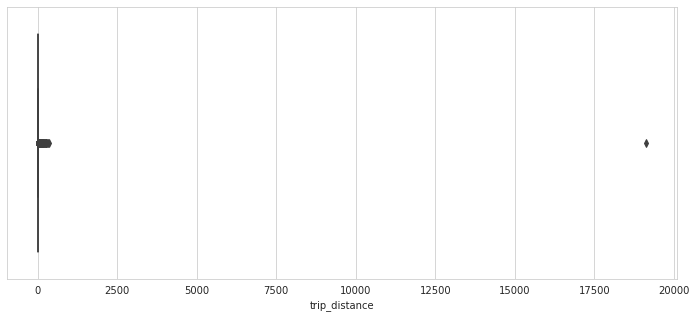

In [ ]:
# plt.figure(figsize=(12,5))
# sns.boxplot(df.trip_distance)

Анализу мешает поездка с аномально высоким расстоянием. Посмотрим на неё.

In [ ]:
df.loc[np.argpartition(-df.trip_distance.values, 1)[:1]]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration_of_trip,store_and_forward_trip,vendor
682715,2019-12-04 10:20:13,2019-12-04 10:24:43,1.0,19130.18,negotiated_fare,N,224,224,cash,11.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,270.0,no,VeriFone


За 4 минуты вряд ли можно проехать 19 тысяч миль. Скорее всего имеет место ошибка в данных, поэтому выбросим эту точку из датасета.

In [ ]:
df.drop(index=682715, inplace=True)
df_ohe.drop(index=682715, inplace=True)

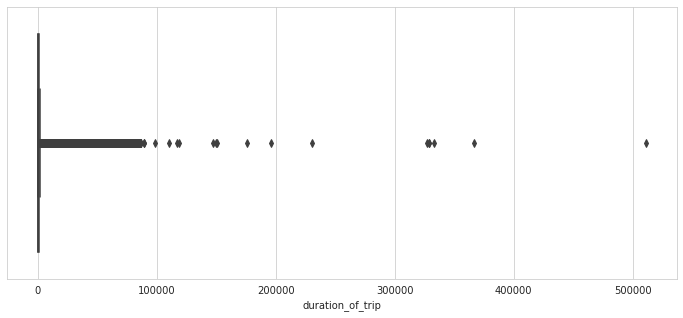

In [ ]:
# plt.figure(figsize=(12,5))
# sns.boxplot(df.duration_of_trip)

Можно видеть очень много выбросов-поездок длительностью дольше дня.
Хотя с учётом трафика мегаполиса можно предположить о том, что отдельные поездки могут длиться многие часов, сложно поверить в поездки длительность более 6 часов. Поэтому для удобства мы исключим эти точки.

In [ ]:
df = df[(df.duration_of_trip < 60 * 60 * 6) & (df.trip_distance < 400)]
df_ohe = df_ohe[(df_ohe.duration_of_trip < 60 * 60 * 6) & (df_ohe.trip_distance < 400)]

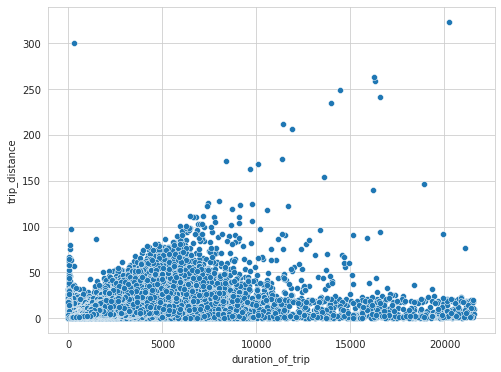

In [ ]:
# plt.figure(figsize=(8,6))
# sns.scatterplot(x=df.duration_of_trip, y=df.trip_distance)

На скаттерплоте можно увидеть линию точек (с одним явным выбросом) с очень маленькой длительностью и достаточно большим расстоянием (от 30 миль и больше). Посмотрим на точке с расстоянием 30 и более миль и длительностью меньше часа.

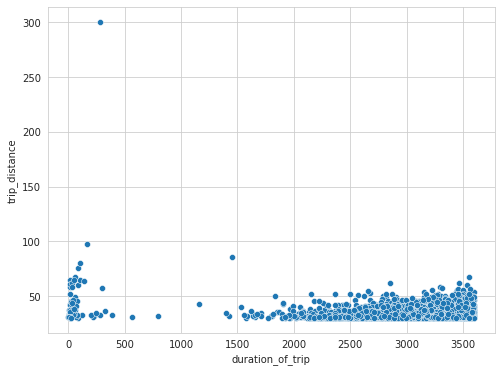

In [ ]:
# plt.figure(figsize=(8,6))
dff = df[(df.trip_distance >= 30) & (df.duration_of_trip < 3600)]
# sns.scatterplot(x=dff.duration_of_trip, y=dff.trip_distance)

Как видим, сильно выделяется область точек с длительностью менее 1000 секунд. Заключим, что это явные выбросы, и удалим их из датасета.  

In [ ]:
inds_to_del = dff[dff.duration_of_trip < 1000].index.tolist()
df.drop(index=inds_to_del, inplace=True, errors='ignore')
df_ohe.drop(index=inds_to_del, inplace=True, errors='ignore')

# Задание 3. Распределение стоимости поездок

Постройте распределение по стоимости поездок. Проверьте гипотезу о том, что оно имеет нормальное распределение. Как вы можете это объяснить?

Посмотрим на распределение целевой переменной.

In [ ]:
df.total_amount.describe()

count    1.274049e+07
mean     1.892425e+01
std      1.433493e+01
min      3.100000e-01
25%      1.130000e+01
50%      1.475000e+01
75%      2.030000e+01
max      6.015800e+03
Name: total_amount, dtype: float64

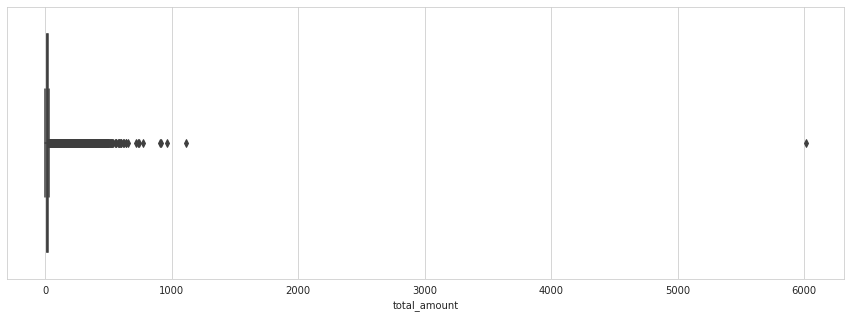

In [ ]:
# plt.figure(figsize=(15,5))
# sns.boxplot(df.total_amount)

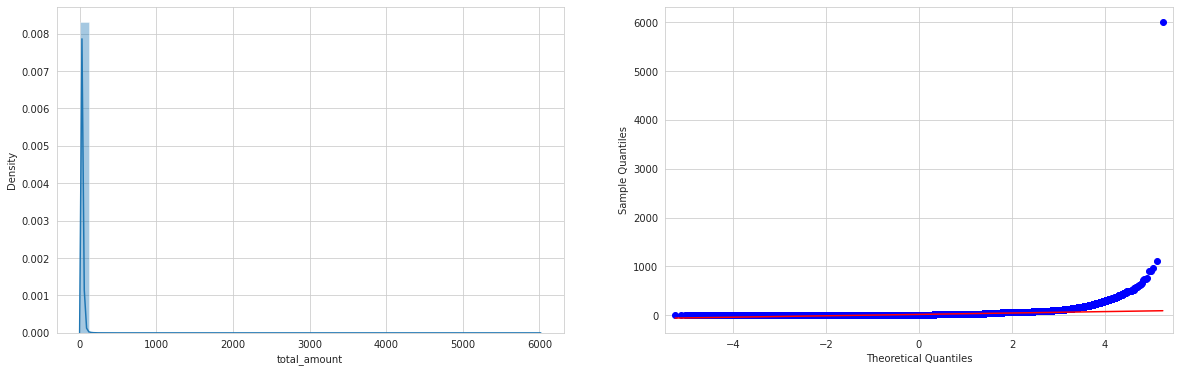

In [ ]:
# fig, ax = plt.subplots(ncols=2, nrows= 1, figsize=(20,6))
# sns.distplot(df.total_amount, ax=ax[0])
# qqplot(df.total_amount, line='s', ax=ax[1], ) 
# plt.show()

Как видим, у распределения переменной огромный правый хвост.

In [ ]:
from scipy.stats import shapiro
stat, p = shapiro(df.total_amount)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.660, p=0.000
Sample does not look Gaussian (reject H0)


Гипотезу о нормальном распределении стоимости поездок можно уверенно отвергнуть.  

Это можно объяснить тем, что отдельные категории поездок (см. Задача 2) стоят значительно больше остальных, а также тем, что в отдельных случаях пассажиры дают огромные чаевые, что и выражается в тяжёлом правом хвосте распределения.

# Задача 4. Предсказательная модель

In [ ]:
df.shape, df_ohe.shape

((12740487, 20), (12740487, 33))

Удалим дату конца поездок (начало понадобится потом для агрегации), а также ID-теги зон, в которых таксиметр был включен/выключен (*PULocationID*, *PULocationID*).

In [ ]:
df.drop(columns=[ 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID'], inplace=True, errors='ignore')
df_ohe.drop(columns=[ 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID'], inplace=True, errors='ignore')

Из данных постройте модель, которая описывает тариф (т.е. стоимость поездки от других факторов).  

Сохраним 2 варианта данных - для градиентного бустинга и линейных моделей (с OHE-признаками). 

In [ ]:
with open('df_for_boost.pickle', 'wb') as f:
     pickle.dump(df, f)

In [ ]:
with open('df_for_reg.pickle', 'wb') as f:
     pickle.dump(df_ohe, f)

In [ ]:
with open('df_for_reg.pickle', 'rb') as f:
     df_ohe = pickle.load(f)

In [ ]:
df_ohe.head()

,tpep_pickup_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration_of_trip,payment_type_cash,payment_type_credit_card,payment_type_dispute,payment_type_no_charge,payment_type_unknown,ratecode_group_ride,ratecode_jfk,ratecode_nassau_or_Westchester,ratecode_negotiated_fare,ratecode_newark,ratecode_standard_rate,ratecode_unknown,store&forward_no,store&forward_yes,vendor_CMT,vendor_VeriFone,store_fwd_N,store_fwd_Y
0,2019-12-01 00:26:58,1.0,4.2,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5,887.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
1,2019-12-01 00:12:03,2.0,9.4,28.5,0.5,0.5,10.00,0.0,0.3,39.80,0.0,1276.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
2,2019-12-01 00:05:27,2.0,1.6,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5,665.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
3,2019-12-01 00:58:51,2.0,1.0,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,586.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
4,2019-12-01 00:19:48,1.0,0.9,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5,270.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0


Для построения модели мы избавимся от признаков-составляющих цены, поскольку они либо обусловлены другими признаками (mta_tax почти всегда зависит от тарифа, либо позникают после поездки (fare_amount расчитывается на основе расстояния, а tip_amount просто случаен и платится клиентом по желанию).

In [ ]:
time = df_ohe.tpep_pickup_datetime

In [ ]:
y = df_ohe.total_amount
X = df_ohe.drop(['tpep_pickup_datetime',
         'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 
         ], axis=1)
del df_ohe

Проведём нормализацию числовых признаков (passenger_count, trip_distance, duration_of_trip)

In [ ]:
scaler = StandardScaler()
scaled_data =  scaler.fit_transform(X.iloc[:, :3])

Переведём данные в формат разряженной таблицы для меньшего расхода памяти

In [ ]:
X_csr = csr_matrix(np.c_[scaled_data, np.array(X.iloc[:, 3:])])
del X

Будем проводить кросс-валидацию с помощью TimeSeriesSplit, разбивающего данные по временному принципу.

In [ ]:
ts_split = TimeSeriesSplit(n_splits=5)

## SGDRegressor

С начала оценим линейную модель

In [ ]:
sgdreg = SGDRegressor(penalty='elasticnet')
params= {'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}
grid = GridSearchCV(sgdreg, params, cv=ts_split, n_jobs=-1, verbose=10, scoring='neg_root_mean_squared_error')
grid.fit(X_csr, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 11.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 13.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='elasticnet',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mea

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
best_sgd = grid.best_estimator_

-4.173949461145655
{'l1_ratio': 0.5}


In [ ]:
from sklearn.metrics import mean_squared_error
pred = best_sgd.predict(X_csr)
mean_squared_error(y, pred, squared=False)

4.54114961225091

## Catboost

Теперь перейдём к градиентному бустингу

Преобразуем данные для бустинга.

In [ ]:
time = df.tpep_pickup_datetime
y = df.total_amount
X = df.drop(['tpep_pickup_datetime',
         'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 
         ], axis=1)

In [ ]:
#Зададаим категориальные признаки
cat_features=df.select_dtypes(include='object').columns.tolist()

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
catboost = CatBoostRegressor(task_type='GPU', iterations=300, random_seed=42, early_stopping_rounds=50, eval_metric='RMSE', verbose=False, 
                             cat_features=df.select_dtypes(include='object').columns.tolist())

In [ ]:
params_cb = {'learning_rate': [0.1, 0.3],
        'depth': [3, 6, 10],
        'l2_leaf_reg': [3, 7]}

In [ ]:
grid_cb = GridSearchCV(catboost, param_grid=params_cb, scoring='neg_root_mean_squared_error', n_jobs=None, cv=ts_split, verbose=10)

In [ ]:
grid_cb.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] depth=10, l2_leaf_reg=7, learning_rate=0.3 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=10, l2_leaf_reg=7, learning_rate=0.3, score=-3.328, total=  34.4s
[CV] depth=10, l2_leaf_reg=7, learning_rate=0.3 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.5s remaining:    0.0s


[CV]  depth=10, l2_leaf_reg=7, learning_rate=0.3, score=-3.219, total=  56.4s
[CV] depth=10, l2_leaf_reg=7, learning_rate=0.3 ......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  depth=10, l2_leaf_reg=7, learning_rate=0.3, score=-3.381, total= 1.3min
[CV] depth=10, l2_leaf_reg=7, learning_rate=0.3 ......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s


[CV]  depth=10, l2_leaf_reg=7, learning_rate=0.3, score=-3.058, total= 1.7min
[CV] depth=10, l2_leaf_reg=7, learning_rate=0.3 ......................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.5min remaining:    0.0s


[CV]  depth=10, l2_leaf_reg=7, learning_rate=0.3, score=-3.172, total= 2.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f50623cc3d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [10], 'l2_leaf_reg': [7],
                         'learning_rate': [0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
print(grid_cb.best_score_)
print(grid_cb.best_params_)
best_cb = grid_cb.best_estimator_

-3.2315215343821784
{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.3}


In [ ]:
pred = best_cb.predict(X)
mean_squared_error(y, pred, squared=False)

3.5772995727383896

Как видим, ошибка на модели бустинга заметно меньше. Для дальнейшего анализа будем использовать именно её.

Посмотрим на наиболее значимые признаки

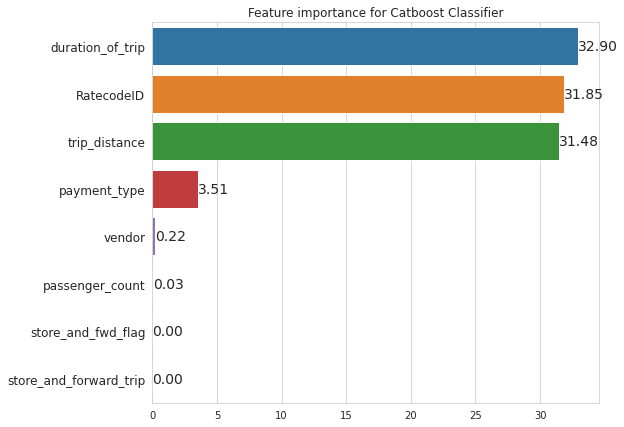

In [ ]:
feat_imp = pd.Series(best_cb.feature_importances_, index=list(X)).sort_values(ascending=False)
plt.figure(figsize=(8,7))
bar = sns.barplot(feat_imp, feat_imp.index)
plt.yticks(size=12)
plt.title('Feature importance for Catboost Classifier')
for p in bar.patches:
    width = p.get_width()    # get bar length
    bar.text(width,  # set the text at bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', # vertical alignment
            fontsize=14)  

Как видим, признаки длительности и расстояния поездки, а также тарифа оказывают наибольшее и близкое по величине влияние.  
Тип оплаты также имеет определённый вклад, тогда как значимость остальных признаков близка к нулю.

# Задание 5. Анализ на наличие скидок

Используя модель из пункта выше ответьте на вопрос: были ли в какие-то дни (или временные промежутки) скидки или акции? И если то были, то как вы можете это объяснить.

In [ ]:
price_by_date =  pd.DataFrame({'time': time, 'true': y, 'pred': pred})

Посмотрим, есть ли выбивающиеся даты.

In [ ]:
price_by_date.time.describe()

count                12740487
unique                4266893
top       2020-01-28 18:18:25
freq                       16
first     2019-12-01 00:00:00
last      2020-01-31 23:58:25
Name: time, dtype: object

Удалим даты, которые выбиваются из интервала декабрь 2019-январь 2020

In [ ]:
price_by_date = price_by_date[(price_by_date.time >= pd.Timestamp('2019-12-01')) & (price_by_date.time <= pd.Timestamp('2020-02-01'))]

In [ ]:
price_by_day = price_by_date.set_index('time').groupby(pd.Grouper(freq='D'))[['true', 'pred']]\
.mean().reset_index()
price_by_day.head()

,time,true,pred
0,2019-12-01,19.605730,19.876108
1,2019-12-02,19.803519,19.771916
2,2019-12-03,19.897357,19.798687
3,2019-12-04,20.228028,20.125093
4,2019-12-05,20.413328,20.284814


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
go.Scatter()
# Create and style traces
fig.add_trace(go.Scatter(x=price_by_day["time"], y=price_by_day["true"], name='true',
                         line=dict(color='firebrick', width=3)))
fig.add_trace(go.Scatter(x=price_by_day["time"], y=price_by_day["pred"], name='pred',
                         line=dict(color='royalblue', width=3)))
# Edit the layout
fig.update_layout(title='Daily prices of taxi rides in NYC',
                   xaxis_title='Day',
                   yaxis_title='Ride price, $')

fig.show()

Как видим, разница между предсказанными и истинными значениями минимальна.

Проведём декомпозицию

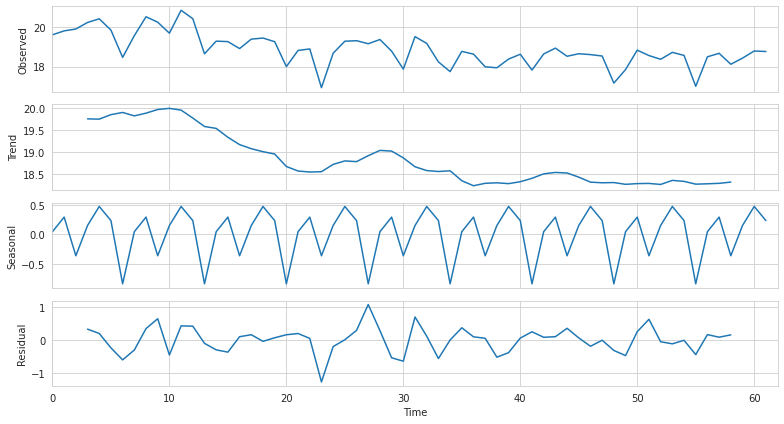

In [ ]:
import pylab
import statsmodels.api as sm
seas = sm.tsa.seasonal_decompose(price_by_day["true"].values, freq=7)
pylab.rcParams['figure.figsize'] = (11, 6)
seas.plot()
plt.show()

Посмотрим подробнее на сезонность

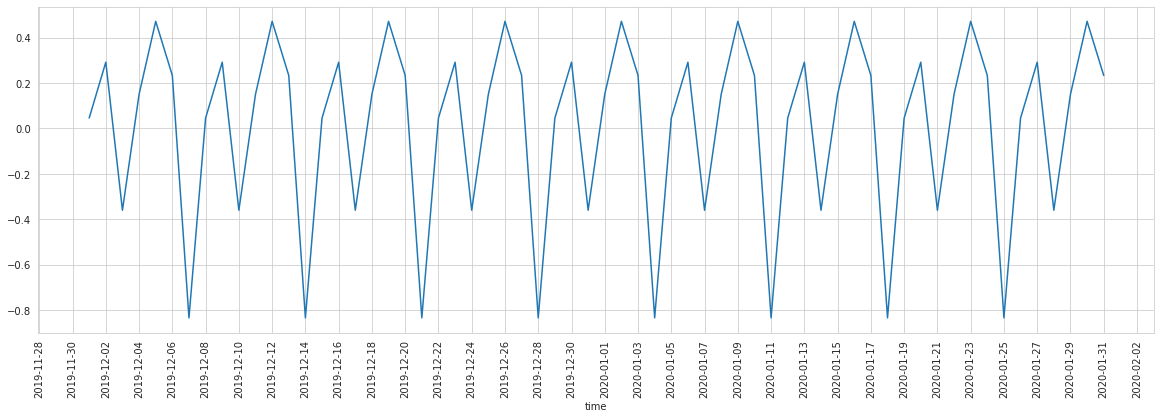

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(20,6))
ax =sns.lineplot(x=price_by_day.time, y = seas.seasonal)
# plt.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.show()

In [ ]:
pd.DataFrame({'date':  price_by_day["time"].dt.date,
    'day_name':price_by_day["time"].dt.day_name()}).set_index('date').T

date,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31
day_name,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday


Судя по графику сезонности, наименьшая цена наблюдается по вторникам и субботам.  
Можно предположить, что именно в эти дни каждую неделю проводятся скидки.

Более подробно посмотрим на данные

In [ ]:
price_by_day['week_name'] = price_by_day["time"].dt.day_name()

In [ ]:
price_by_day

In [ ]:
px.line(price_by_day, x='time', y='true', title='Daily prices of taxi rides in NYC', hover_data=['week_name'], lin)

Как видим, наибольшие спады средней цены фиксируются действительно по субботам, тогда как спады по вторникам гораздо меньшей почти на всём протяжении временного периода.  
Единственным исключением можно назвать неделю 23 декабря - 30 декабря, где в субботу не наблюдается никакого спада, однако спад наблюдается во вторник 24 декабря.  
Это можно объяснить особенной щедрой акцией, устроенной в предверии Рождества и перенесённой с субботы.  
Также падение наблюдается 31 декабря во вторник, которое можно объяснить, как скидкой в честь нового года, так и низким спросом из-за выходного дня. 